In [1]:
import pandas 
import numpy 
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import matplotlib as mpl

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_montecarlo_oil_byvessel, get_montecarlo_oil, get_montecarlo_df
from monte_carlo_utils import get_DOE_oilclassification, get_DOE_df, rename_DOE_df_oils, get_doe_transfers
from monte_carlo_utils import assign_spill_region, get_montecarlo_oil_byregion, get_voyage_transfers
from monte_carlo_utils import get_DOE_quantity_byfac, get_DOE_quantity, assign_facility_region

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

# Facility names and lat/lon information file
facilities_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'Oil_Transfer_Facilities.xlsx'
)

# 10,000 monte carlo spills
monte_carlo_csv = Path(
    '/Users/rmueller/Data/MIDOSS/monte_carlo/'
    'SalishSeaOilSpills_fixbarge_10000_1.csv'
)

# Voyage dataset
CamSheet = '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/Documents/'\
    'Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/origin-destination/'\
    'Origin_Destination_Analysis_updated.xlsx'

# Oil Attribution file 
oil_attribution_file = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'oil_attribution.yaml'
)

# location of output excel spreadsheets
output_directory = Path(
    '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
)
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# location of output .tex documents for writing tables to file
tex_dir = Path(
    '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/'
    'Documents/Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/'
    'notes/python_generated_tables')

data_types = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

# graphic font specifications
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

In [3]:
# Oil Attribution File
with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# Facility information 
facdf = assign_facility_region(facilities_xlsx)

# load DOE data such that the three terminals that are grouped in our
# origin-destination analysis are re-named to the terminal that they
# are grouped with in our analysis. Also assigns regions to transfers
DOEdf = get_DOE_df(
    DOE_2018_xlsx, 
    facilities_xlsx,
    group = 'yes'
)

DOEdf = rename_DOE_df_oils(DOEdf, DOE_2018_xlsx)

# New method converts DOE facility names to monte-carlo facility names
# in `get_DOE_df` function of `monte_carlo_utils.py`, so I now use the 
# monte_carlo names uniformly to query both DOE and monte-carlo facilities
facility_names = oil_attrs['categories']['US_origin_destination']

---
### Plot transfers by region
---

In [4]:
# Get proxy for transfers from AIS data by tallying the number of 
# voyages that have an origin or destination given by one of our
# marine terminals
voyage_transfers = get_voyage_transfers(CamSheet, facilities_xlsx)
voyage_transfers.head(3)

,tanker_transfers,barge_transfers,atb_transfers,Region
LOCATION,,,,
Alon Asphalt Company (Paramount Petroleum),2.0,559.0,0.0,Puget Sound
BP Cherry Point Refinery,447.0,1500.0,627.0,Whatcom County
Kinder Morgan Liquids Terminal - Harbor Island,110.0,7501.0,219.0,Puget Sound


In [5]:
# Get number of transfers per marine terminal recorded by DOE, 
# sorted by vessel type receiving or delivering product.  
# Format: df[vessel_type]
doe_transfers = get_doe_transfers(DOE_2018_xlsx, facilities_xlsx)

In [6]:
for vessel in ['tanker','atb','barge']:
    print(vessel.upper())
    print(doe_transfers[vessel])

TANKER
                                                combined  exports  imports  \
LOCATIONS                                                                    
BP Cherry Point Refinery                           316.0    171.0    145.0   
Shell Puget Sound Refinery                         227.0    130.0     97.0   
Shell Oil LP Seattle Distribution Terminal           0.0      0.0      0.0   
Maxum Petroleum - Harbor Island Terminal            36.0     34.0      2.0   
Tidewater Snake River Terminal                       1.0      0.0      1.0   
Nustar Energy Tacoma                                 0.0      0.0      0.0   
SeaPort Sound Terminal                               1.0      0.0      1.0   
Tesoro Vancouver Terminal                            2.0      1.0      1.0   
Phillips 66 Ferndale Refinery                       49.0      4.0     45.0   
Phillips 66 Tacoma Terminal                          0.0      0.0      0.0   
Marathon Anacortes Refinery (formerly Tesoro)      258.0 

### Plot voyage and DOE transfers, grouped by region, for each vessel type

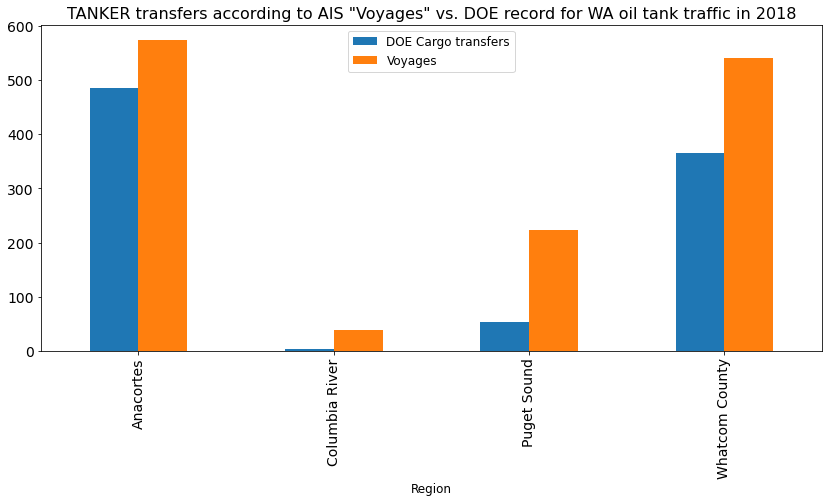

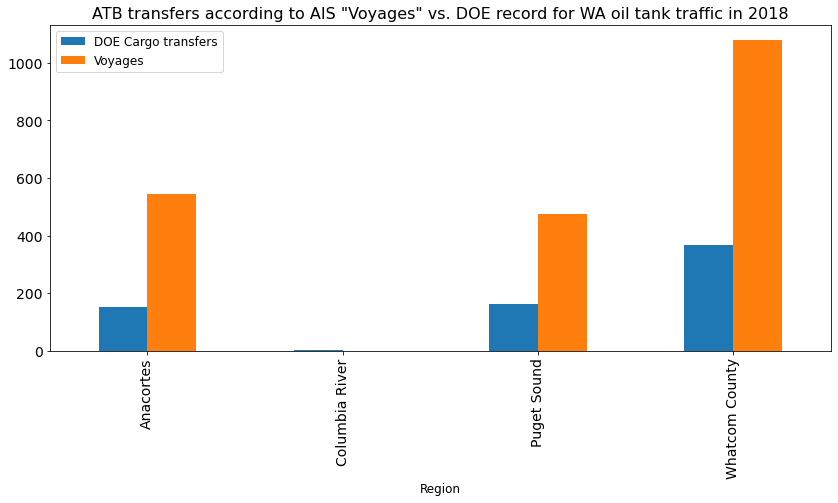

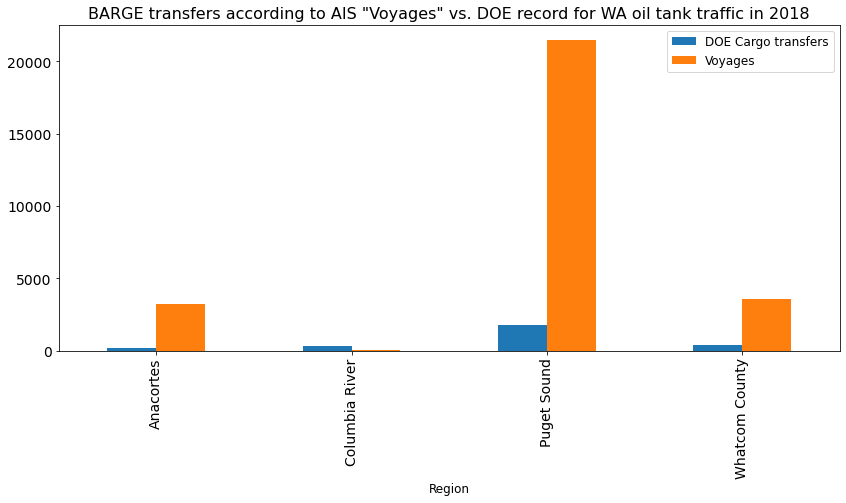

In [7]:
regional_total = {}
for vessel in ['tanker','atb','barge']:
    regional_total[vessel] = doe_transfers[vessel].groupby(
        'Region'
    ).combined.sum().to_frame().rename(
        columns={'combined':'DOE (Cargo)'}
    )

    regional_total[vessel] = pandas.merge(
        left=regional_total[vessel], 
        right=voyage_transfers.groupby(
            'Region'
        )[f'{vessel}_transfers'].sum().to_frame(),
        left_index = True,
        right_index=True,
        how='left'
    ).fillna(0).rename(columns={f'{vessel}_transfers':'Voyages'})
    regional_total[vessel].plot(
        y=['DOE (Cargo)', 'Voyages'], 
        label=['DOE Cargo transfers', 'Voyages'],
        kind = "bar",
        figsize=(14,6),
        fontsize=14
    )
    plt.title(f'{vessel.upper()} '
              'transfers according to AIS "Voyages" vs. DOE record'
              ' for WA oil tank traffic in 2018'
             )
    #plt.savefig(graphics_directory/'barge_transfers_voyage_DOE_mc.png',bbox_inches='tight')
    plt.show()    

In [8]:
for vessel in ["tanker","atb","barge"]:
    transfer_ratio_byregion = regional_total[vessel]['Voyages']/regional_total[vessel]['DOE (Cargo)']
    transfer_ratio = regional_total[vessel]['Voyages'].sum()/regional_total[vessel]['DOE (Cargo)'].sum()
    print(vessel.upper(),'Voyages/DOE transfer ratio')
    print(transfer_ratio_byregion)
    print(f'Total: {transfer_ratio:.2f}')

TANKER Voyages/DOE transfer ratio
Region
Anacortes          1.183505
Columbia River    12.666667
Puget Sound        4.148148
Whatcom County     1.482192
dtype: float64
Total: 1.52
ATB Voyages/DOE transfer ratio
Region
Anacortes         3.549020
Columbia River    0.000000
Puget Sound       2.956522
Whatcom County    2.948087
dtype: float64
Total: 3.07
BARGE Voyages/DOE transfer ratio
Region
Anacortes         17.292553
Columbia River     0.101449
Puget Sound       11.850442
Whatcom County     8.306075
dtype: float64
Total: 10.21


---
### Plot regional oil transfers
---

#### monte_carlo file

In [9]:
transfers_mc = {}
for vessel in ["tanker","atb","barge"]:
    transfers_mc[vessel] = {}
    transfers_mc[vessel] = get_montecarlo_oil_byvessel(vessel, monte_carlo_csv)

In [10]:
#mcdf = get_montecarlo_df(monte_carlo_csv)
#mcdf = assign_spill_region(mcdf)

In [11]:
capacities=get_montecarlo_oil_byregion(
    monte_carlo_csv, oil_attribution_file, facilities_xlsx,
    direction = 'export', vessel='tanker'
)

In [12]:
capacities.head()

,cargo_capacity,vessel_origin,oil_type,SpillRegion,ExportRegion
13,185447000.0,Shell Puget Sound Refinery,Bunker-C,Puget Sound,Anacortes
44,53000000.0,BP Cherry Point Refinery,Diesel,Puget Sound,Whatcom County
262,53000000.0,BP Cherry Point Refinery,Diesel,Whatcom,Whatcom County
605,53000000.0,Marathon Anacortes Refinery (formerly Tesoro),Diesel,Anacortes,Anacortes
2117,185447000.0,Shell Puget Sound Refinery,Gasoline,Anacortes,Anacortes


In [13]:
regions = ['Columbia River','Puget Sound','Anacortes','Whatcom County']
# names of oil groupings that we want for our output/graphics
oil_types_graphics = [
    'ANS', 'Bunker-C', 'Dilbit',
    'Jet Fuel', 'Diesel', 'Gasoline',
    'Other'
]
#~~~ IMPORTS ~~~
oil_transfers_mc = {}
count_transfers_mc = {}
for vessel in ["tanker","atb","barge"]:
    oil_transfers_mc[vessel] = {}
    count_transfers_mc[vessel] = {}
    oil_transfers_mc[vessel]['import'] = {}
    count_transfers_mc[vessel]['import'] = {}
    # load oil capacities from monte-carlo file
    capacities=get_montecarlo_oil_byregion(
        monte_carlo_csv, oil_attribution_file, facilities_xlsx,
        direction = 'import', vessel=vessel
    )
    # Create a dictionary of zero values for each region
    count_transfers_mc[vessel]['import'] = dict(
        (region,0) for region in regions
    )
    oil_transfers_mc[vessel]['import'] = dict(
        (region,{}) for region in regions
    )
    # Count transfers by vessel and region
    mc_import = capacities.groupby('ImportRegion').cargo_capacity.count().to_dict()
    for key in count_transfers_mc[vessel]['import'].keys():
        if key in mc_import.keys():
            count_transfers_mc[vessel]['import'][key] = (
                count_transfers_mc[vessel]['import'][key] + mc_import[key]
            )
    for region in regions:
        # if there were transfers in given region then evaluation oil_types
        if count_transfers_mc[vessel]['import'][region]: 
             for oil in oil_types_graphics:
                # Add volume of oil by oil-type using cargo_capacity to attribute  
                oil_transfers_mc[vessel]['import'][region][oil] = capacities.loc[
                    (capacities.oil_type == oil),
                    ['cargo_capacity', 'oil_type']
                ].cargo_capacity.sum()
        else: # I'm sure there is a more pythonic way to do this!
            for oil in oil_types_graphics:
                oil_transfers_mc[vessel]['import'][region][oil] = 0  

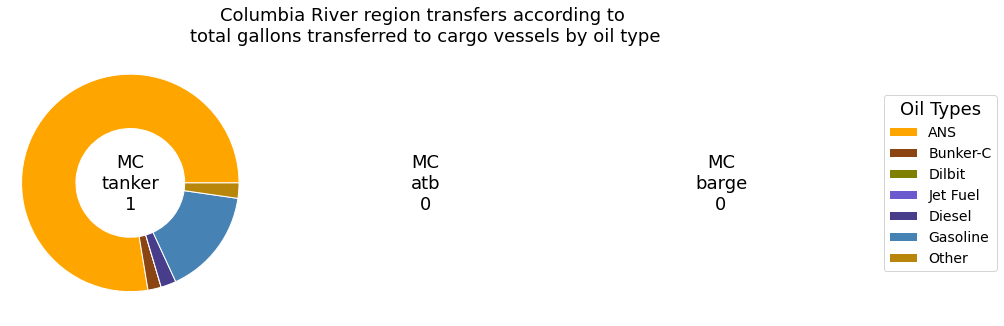

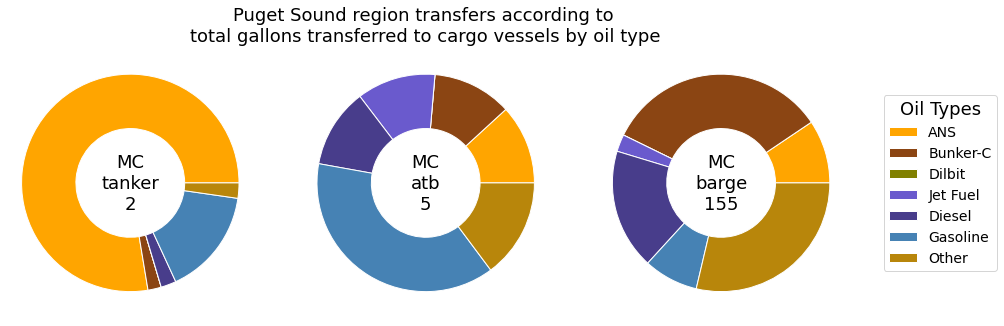

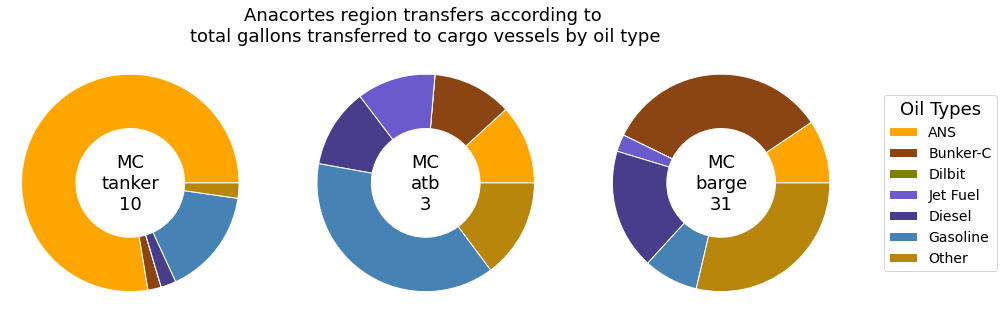

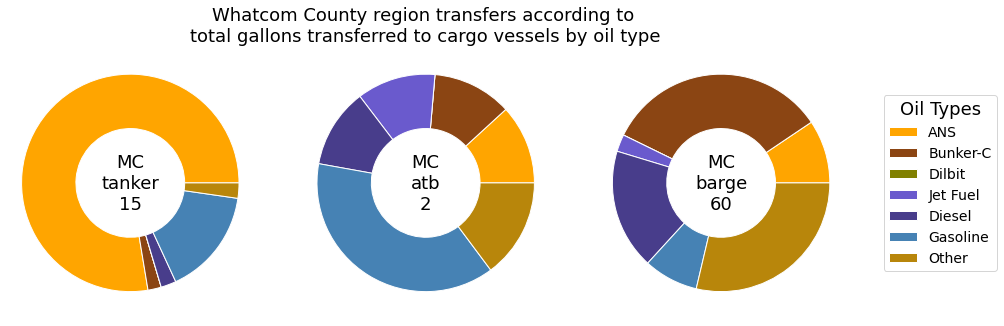

In [14]:
#--------------------------------------------------------------------------------
## Plot monte_carlo transfers 
#--------------------------------------------------------------------------------
for region in ['Columbia River','Puget Sound','Anacortes','Whatcom County']:
    fig, axes = plt.subplots(1, 3, figsize = (15,5))
    for idx,vessel in enumerate(["tanker","atb","barge"]):
        # add central title
        axes[idx].axis('equal') 
        if idx==1:
            axes[idx].set_title(
                (f'{region} region transfers according to \n'
                 'total gallons transferred to cargo vessels by oil type'),
                fontsize=18
            )
        
        # bake an oil pie
        if count_transfers_mc[vessel]['import'][region]>0:
            pie_wedge_collection  = axes[idx].pie(
                oil_transfers_mc[vessel]['import'][region].values(),
                wedgeprops=dict(width=0.5),
                textprops={'fontsize': 14}
            )

        # make colors uniform across subplots
        for pidx,pie_wedge in enumerate(pie_wedge_collection[0]):
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(colordict[list(
                oil_transfers_mc[vessel]['import'][region].keys()
            )[pidx]])
        axes[idx].axis('off')
        count_str = count_transfers_mc[vessel]['import'][region]
        axes[idx].text(
            0,0,f'MC\n{vessel}\n{count_str}',
            ha='center',
            va='center',
            fontsize=18
        )
        if idx==0:
            axes[idx].legend(
                oil_transfers_mc[vessel]['import'][region].keys(),
                fontsize=14,
                title_fontsize=18,
                title="Oil Types",
                bbox_to_anchor=(4.05, 0.85)
            )
    plt.savefig(graphics_directory/f'MC_oil_transfers_byregion_{region}.png')

#### department of ecology data

In [15]:
# get list of oils grouped by our monte_carlo oil types
oil_types = [
    'akns', 'bunker', 'dilbit', 
    'jet', 'diesel', 'gas', 'other'
]
# names of oil groupings that we want for our output/graphics
oil_types_graphics = [
    'ANS', 'Bunker-C', 'Dilbit',
    'Jet Fuel', 'Diesel', 'Gasoline',
    'Other'
]
oil_classification = get_DOE_oilclassification(DOE_2018_xlsx)

region = 'puget'
transfers = {}
for vessel in ["tanker","atb","barge"]:
    transfers[vessel] = {}
    transfers[vessel]['import'] = {}
    transfers[vessel]['export'] = {}
## IMPORTS
for region in ['Columbia River','Puget Sound','Anacortes','Whatcom County']:
    transfers['tanker']['import'][region] = {}
    transfers['atb']['import'][region] = {}
    transfers['barge']['import'][region] = {}
    # tanker transfers by region
    transfers['tanker']['import'][region] = DOEdf.loc[
        (DOEdf['ImportRegion'] == region) &
        (DOEdf['TransferType'] == 'Cargo') & 
        (DOEdf['DelivererTypeDescription'].isin(['TANK SHIP']) | 
         DOEdf['ReceiverTypeDescription'].isin(['TANK SHIP'])),
        ['TransferQtyInGallon','Product']
    ]
    # atb transfers by region
    transfers['atb']['import'][region] = DOEdf.loc[
        (DOEdf['ImportRegion'] == region) &
        (DOEdf['TransferType'] == 'Cargo') & 
        (DOEdf.Deliverer.str.contains('ITB') | 
         DOEdf.Deliverer.str.contains('ATB') | 
         DOEdf.Receiver.str.contains('ITB') | 
         DOEdf.Receiver.str.contains('ATB')),
        ['TransferQtyInGallon','Product']
    ]
    # barge transfers by region
    transfers['barge']['import'][region] = DOEdf.loc[
        (DOEdf['ImportRegion'] == region) &
        (DOEdf['TransferType'] == 'Cargo') &  
        (~DOEdf.Deliverer.str.contains('ITB')) & 
        (~DOEdf.Deliverer.str.contains('ATB')) & 
        (~DOEdf.Receiver.str.contains('ITB')) & 
        (~DOEdf.Receiver.str.contains('ATB')) &
        (DOEdf.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])|
         DOEdf.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
        ['TransferQtyInGallon','Product']
    ]

#~~~ IMPORTS ~~~
oil_transfers = {}
count_transfers = {}
for vessel in ["tanker","atb","barge"]:
    oil_transfers[vessel] = {}
    count_transfers[vessel] = {}
    oil_transfers[vessel]['import'] = {}
    count_transfers[vessel]['import'] = {}
    for region in ['Columbia River','Puget Sound','Anacortes','Whatcom County']:
        oil_transfers[vessel]['import'][region] = {}
        count_transfers[vessel]['import'][region] = len(transfers[vessel]['import'][region])
        # Count oil transfers if they exist in region for given vessel type
        if len(transfers[vessel]['import'][region]):
            for oil in oil_types_graphics:
                oil_transfers[vessel]['import'][region][oil] = transfers[vessel]['import'][region].loc[
                    (transfers[vessel]['import'][region].Product == oil),
                    ['TransferQtyInGallon', 'Product']
                ].TransferQtyInGallon.sum()
        else: # I'm sure there is a more pythonic way to do this!
            for oil in oil_types_graphics:
                oil_transfers[vessel]['import'][region][oil] = 0  

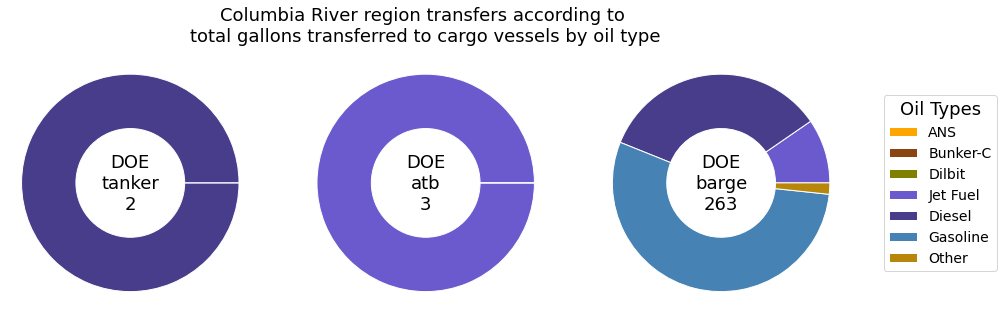

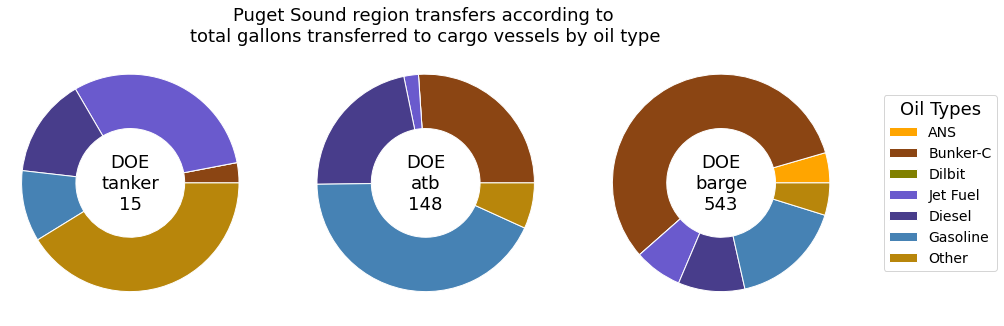

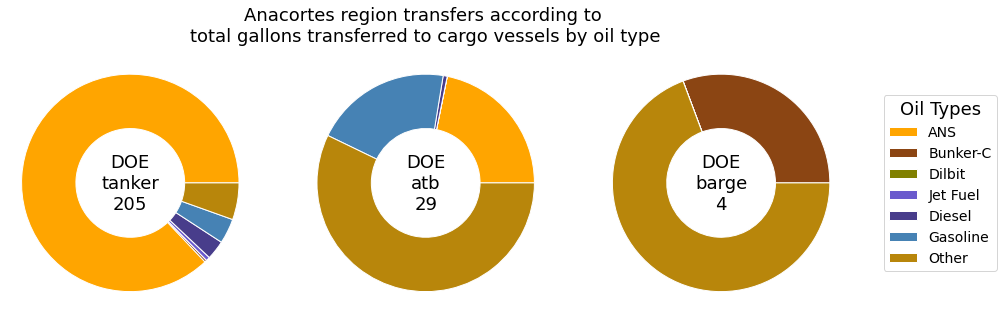

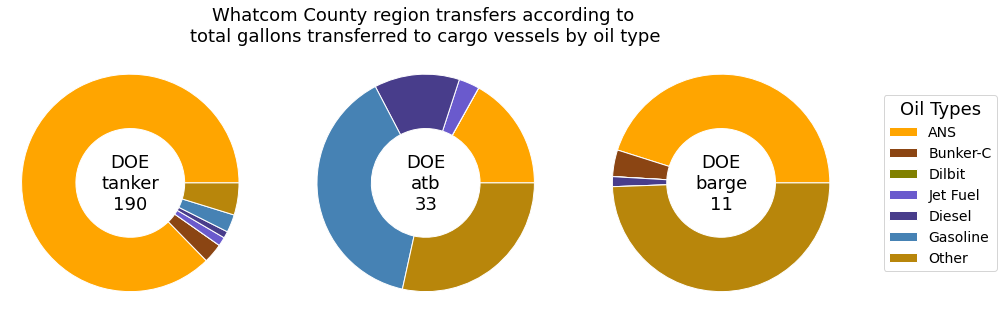

In [16]:
#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
for region in ['Columbia River','Puget Sound','Anacortes','Whatcom County']:
    fig, axes = plt.subplots(1, 3, figsize = (15,5))
    for idx,vessel in enumerate(["tanker","atb","barge"]):
        # add central title
        axes[idx].axis('equal') 
        if idx==1:
            axes[idx].set_title(
                (f'{region} region transfers according to \n'
                 'total gallons transferred to cargo vessels by oil type'),
                fontsize=18
            )
        # plot up results      
        if count_transfers[vessel]['import'][region]>0:
            pie_wedge_collection  = axes[idx].pie(
                oil_transfers[vessel]['import'][region].values(),
                wedgeprops=dict(width=0.5),
                textprops={'fontsize': 14}
            )
        # make colors uniform across subplots
        for pidx,pie_wedge in enumerate(pie_wedge_collection[0]):
            pie_wedge.set_edgecolor('white')
            pie_wedge.set_facecolor(colordict[list(
                oil_transfers[vessel]['import'][region].keys()
                )[pidx]]
            )
        axes[idx].axis('off')
        count_str = count_transfers[vessel]['import'][region]
        axes[idx].text(
            0,0,f'DOE\n{vessel}\n{count_str}',
            ha='center',
            va='center',
            fontsize=18
        )
        if idx==0:
            axes[idx].legend(
                oil_transfers[vessel]['import'][region].keys(),
                fontsize=14,
                title_fontsize=18,
                title="Oil Types",
                bbox_to_anchor=(4.05, 0.85)
            )
    plt.savefig(graphics_directory/f'DOE_oil_transfers_byregion_{region}.png')